In [220]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [221]:
StartDate = "2017-11-09"
EndDate = "2023-10-17"

df = yf.download("BTC-USD ETH-USD XMR-USD GC=F HG=F ^GSPC", start=StartDate, end=EndDate, group_by='tickers')
df.drop('Adj Close', axis=1, level=1, inplace=True)
df.columns = df.columns.map(' '.join).str.strip(' ')

[*********************100%%**********************]  6 of 6 completed


In [222]:
df_train = df[df.index < pd.to_datetime('2023-09-08')]
df_test = df[(df.index > pd.to_datetime('2023-09-07')) & (df.index < pd.to_datetime('2023-10-09'))]

In [223]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
df_imputed_train = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns, index=df_train.index)
df_imputed_test = pd.DataFrame(imputer.transform(df_test), columns=df_test.columns, index=df_test.index)

In [224]:
df_imputed_concat = pd.concat([df_imputed_train, df_imputed_test])

In [225]:
close_list = ['^GSPC Close', 'HG=F Close', 'GC=F Close', 'XMR-USD Close', 'BTC-USD Close', 'ETH-USD Close']
for cols in close_list:
    col_name = cols.replace(' Close', '')
    df_imputed_concat[f'{col_name} Change'] = df_imputed_concat[cols].diff()
    df_imputed_concat[f'{col_name} Percentage Change'] = df_imputed_concat[cols].pct_change()

    change_up = df_imputed_concat[f'{col_name} Change'].copy()
    change_down = df_imputed_concat[f'{col_name} Change'].copy()
    
    change_up[change_up<0] = 0
    change_down[change_down>0] = 0
    
    avg_up = change_up.rolling(14).mean()
    avg_down = change_down.rolling(14).mean().abs()
    
    df_imputed_concat[f'{col_name} RSI'] = 100 * avg_up / (avg_up + avg_down)
    df_imputed_concat.drop(columns=f'{col_name} Change', inplace=True)

df_imputed_concat['Target'] = df_imputed_concat['XMR-USD Percentage Change'].shift(-1).apply(lambda x: 0 if x < 0 else 1)
df_imputed_concat.dropna(inplace=True)

In [226]:
train = df_imputed_concat[df_imputed_concat.index < pd.to_datetime('2023-09-08')]
test = df_imputed_concat[(df_imputed_concat.index > pd.to_datetime('2023-09-07')) & (df_imputed_concat.index < pd.to_datetime('2023-10-08'))]

In [227]:
if input('Enter 1 to save data to CSV files') == '1':
    train.to_csv('random_forest_train.csv')
    test.to_csv('random_forest_test.csv')

Enter 1 to save data to CSV files 


In [234]:
# Prepare data for the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = train.drop(columns='Target')
y = train['Target']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=13)
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_validation = std_scaler.transform(X_validation)

In [235]:
# Fit the data
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=1)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       916
           1       1.00      1.00      1.00       987

    accuracy                           1.00      1903
   macro avg       1.00      1.00      1.00      1903
weighted avg       1.00      1.00      1.00      1903

Validation Data
              precision    recall  f1-score   support

           0       0.51      0.46      0.48        91
           1       0.62      0.66      0.64       121

    accuracy                           0.58       212
   macro avg       0.56      0.56      0.56       212
weighted avg       0.57      0.58      0.57       212

Test Data
              precision    recall  f1-score   support

           0       0.50      0.17      0.25        12
           1       0.62      0.89      0.73        18

    accuracy                           0.60        30
   macro avg       0.56      0.53      0.49        30
weighted avg       0.57      0.60 

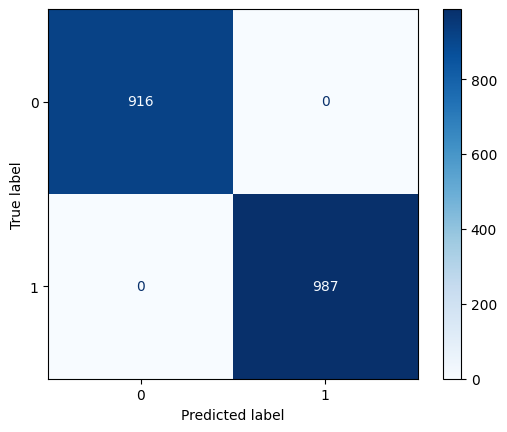

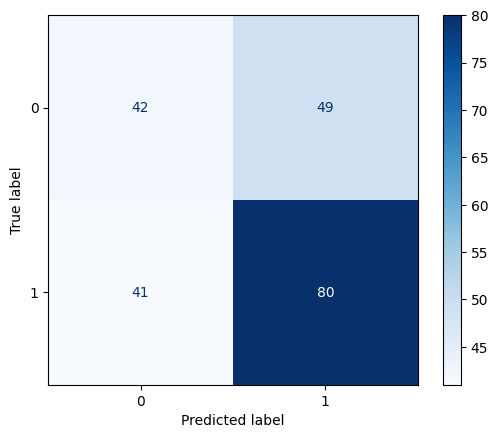

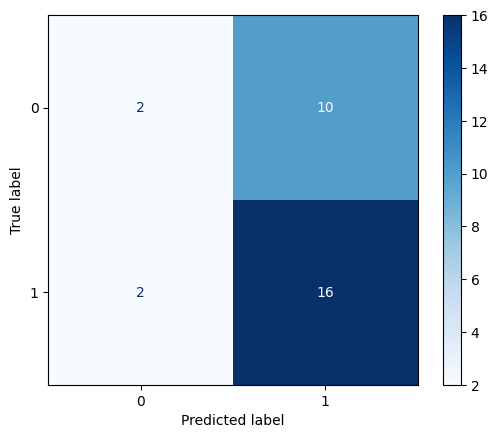

In [277]:
# Training and validation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_train = classifier.predict(X_train)
print(f'Training Data\n{classification_report(y_train, y_pred_train)}')
ConfusionMatrixDisplay.from_estimator(classifier, X_train, y_train, cmap='Blues')
y_pred_validation = classifier.predict(X_validation)
print(f'Validation Data\n{classification_report(y_validation, y_pred_validation)}')
ConfusionMatrixDisplay.from_estimator(classifier, X_validation, y_validation, cmap='Blues')

# test data metrics
X_test = test.drop(columns='Target')
X_test = std_scaler.transform(X_test)
y_test = test['Target']
y_pred_test = classifier.predict(X_test)
print(f'Test Data\n{classification_report(y_test, y_pred_test)}')
print(f'Class 1 predictions : {len(y_pred_test[y_pred_test == 1])}')
print(f'Class 0 predictions : {len(y_pred_test[y_pred_test == 0])}')
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, cmap='Blues');